<h1 align="center">Problem 3 - Practical HBM</h1>
<h2 align="center">Joint Orbital Period Breakpoint and Eccentricity Distribution Hierarchical Bayesian Model for Eclipsing Binaries with PyJAGS</h2>
<h3 align="center">Simulating a joint eccentricity and Period distribution of Eclpising Binaries from the Kepler Mission</h3> 
<h4 align="center">LSSTC DSFP Session 4, September 21st, 2017</h4>
<h5 align="center">Author: Megan I. Shabram, PhD, 
NASA Postdoctoral Program Fellow,  mshabram@gmail.com</h5>

Using the JAGS model code block for a break-point HBM provided below, set up and evaluate the break-point HBM on the real Kepler eclipsing binary data set. Some code and the datafile is provided for analysis, but you may also want to copy code from previous notebooks, and be sure to adjust the number of traceplots and 2d marginals for latent variables (e.g., don't plot all ~700 latent variable marginal posteriors etc.). There is some wait time involved during the MCMC computation.  

In [2]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import pyjags
import pystan
import pickle
import triangle_linear

from IPython.display import display, Math, Latex
from __future__ import division, print_function
from pandas.tools.plotting import *
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
#plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%qtconsole


In [3]:
## Read in Eclipsing Binary dataset containing projected eccentricity and orbital periods.
df_EB = pd.read_csv('EBs_for_jags.txt', delimiter=r"\s+")
print(df_EB)

print(len(df_EB.loc[:, "H_OBS"]))

## the only columns you need are P, H_OBS, K_OBS, H_SIGMA, and K_SIGMA

           ID           P     H_OBS   H_SIGMA     K_OBS   K_SIGMA  x1  x2  \
0     1026032    8.460438 -0.041576  0.000035  0.002119  0.004618   1   1   
1     1433980    1.592634 -0.000387  0.000103  0.014743  0.001303   1   1   
2     1571511   14.022451 -0.042219  0.000566  0.231536  0.023805   1   1   
3     1995732   77.362721 -0.131261  0.000044  0.079461  0.004085   1   1   
4     2019076    7.129228  0.000058  0.000020 -0.003283  0.003716   1   1   
5     2161623    2.283470  0.001422  0.000052 -0.040365  0.002232   1   1   
6     2162994    4.101596  0.000202  0.000010 -0.001038  0.000444   1   1   
7     2305372    1.404692  0.004280  0.000024 -0.028196  0.000683   1   1   
8     2306740   10.306987 -0.023318  0.000008  0.295810  0.000564   1   1   
9     2307206  204.031379 -0.010914  0.000035  0.199013  0.020766   1   1   
10    2442084   49.788598 -0.502625  0.000490 -0.304308  0.002906   1   1   
11    2445134    8.412009  0.000959  0.000219 -0.006187  0.008268   1   1   

In [4]:
code = '''

model {
    
    # Period break point hyper parameter:
    p_break ~ dunif(0.001,20)

    #Population parameters
    for (j in 1:Nm) {
        e_sigma_a[j] ~ dunif(0, 1)
        e_phi_a[j] <- 1/(e_sigma_a[j]*e_sigma_a[j])
        a[j] <- 1;
    }
    
    e_sigma_b ~ dunif(0.,1.)
    e_phi_b <- 1/(e_sigma_b*e_sigma_b)
    
    f_a ~ ddirch(a[])

    for (n in 1:Ndata){

        c_a[n] ~ dcat(f_a[])

        e_phi_ref[n] <- ifelse(P[n] < p_break, e_phi_b ,e_phi_a[c_a[n]])

        #True planet properties
        h[n] ~ dnorm(0, e_phi_ref[n]) T(-1,1)
        k[n] ~ dnorm(0, e_phi_ref[n]) T(-sqrt(1-h[n]*h[n]),sqrt(1-h[n]*h[n]))
    
        #Observed planet properties
        hhat[n] ~ dnorm(h[n], 1.0/(hhat_sigma[n]*hhat_sigma[n])) T(-1,1)
        khat[n] ~ dnorm(k[n], 1.0/(khat_sigma[n]*khat_sigma[n])) T(-sqrt(1-hhat[n]*hhat[n]),sqrt(1-hhat[n]*hhat[n]))
    }
        
}
'''




In [5]:
## Load additional JAGS module
pyjags.load_module('glm')
pyjags.load_module('dic')


## See blog post for origination of the adapted analysis tools used here and below:
## https://martynplummer.wordpress.com/2016/01/11/pyjags/

num_chains = 4
iterations = 10000


## data list include only variables in the model
model = pyjags.Model(code, data=dict(Nm=2, Ndata=len(df_EB.loc[:, "P"]), P=df_EB.loc[:, "P"], 
                                     hhat_sigma=df_EB.loc[:, "H_SIGMA"], khat=df_EB.loc[:, "K_OBS"], 
                                     khat_sigma=df_EB.loc[:, "K_SIGMA"]), 
                     chains=num_chains, adapt=1000)

## Code to speed up compute time. This feature might not be 
## well tested in pyjags at this time. 
## threads=4, chains_per_thread=1 

## 500 warmup / burn-in iterations, not used for inference.
model.sample(500, vars=[])

## Run model for desired steps, monitoring hyperparameter variables, and latent variables
## for hierarchical Bayesian model.
## Returns a dictionary with numpy array for each monitored variable.
## Shapes of returned arrays are (... shape of variable ..., iterations, chains).
## samples = model.sample(#iterations per chain here, vars=['e_sigma', 'h'])
samples_JAGS = model.sample(iterations, vars=['p_break','e_sigma_a', 'e_sigma_b', 'f_a' ])

## Code to save, open and use pickled dictionary of samples:
## -- Pickle the data --
#with open('ecc_1_test.pkl', 'wb') as handle:
#   pickle.dump(samples, handle)
## -- Retrieve pickled data --
#with open('ecc_1_test.pkl', 'rb') as handle:
#   retrieved_results = pickle.load(handle)


adapting: iterations 88 of 4000, elapsed 0:00:06, remaining 0:04:31
adapting: iterations 240 of 4000, elapsed 0:00:13, remaining 0:03:22
adapting: iterations 440 of 4000, elapsed 0:00:18, remaining 0:02:25
adapting: iterations 692 of 4000, elapsed 0:00:25, remaining 0:01:58
adapting: iterations 976 of 4000, elapsed 0:00:32, remaining 0:01:38
adapting: iterations 1284 of 4000, elapsed 0:00:42, remaining 0:01:29
adapting: iterations 1436 of 4000, elapsed 0:00:48, remaining 0:01:25
adapting: iterations 1584 of 4000, elapsed 0:00:53, remaining 0:01:21
adapting: iterations 1732 of 4000, elapsed 0:01:00, remaining 0:01:18
adapting: iterations 1876 of 4000, elapsed 0:01:07, remaining 0:01:16
adapting: iterations 2012 of 4000, elapsed 0:01:13, remaining 0:01:12
adapting: iterations 2148 of 4000, elapsed 0:01:19, remaining 0:01:08
adapting: iterations 2284 of 4000, elapsed 0:01:24, remaining 0:01:03
adapting: iterations 2420 of 4000, elapsed 0:01:29, remaining 0:00:58
adapting: iterations 2552 

0.316326554665


([array([   0.,   10.,  259.,  528.,  191.,   12.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,  101.,  564.,  322.,   13.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,   98.,  753.,  149.]),
  array([ 124.,  456.,  376.,   44.,    0.,    0.,    0.,    0.,    0.,    0.])],
 array([ 0.25117101,  0.29442125,  0.3376715 ,  0.38092174,  0.42417198,
         0.46742223,  0.51067247,  0.55392271,  0.59717296,  0.6404232 ,
         0.68367345]),
 <a list of 4 Lists of Patches objects>)

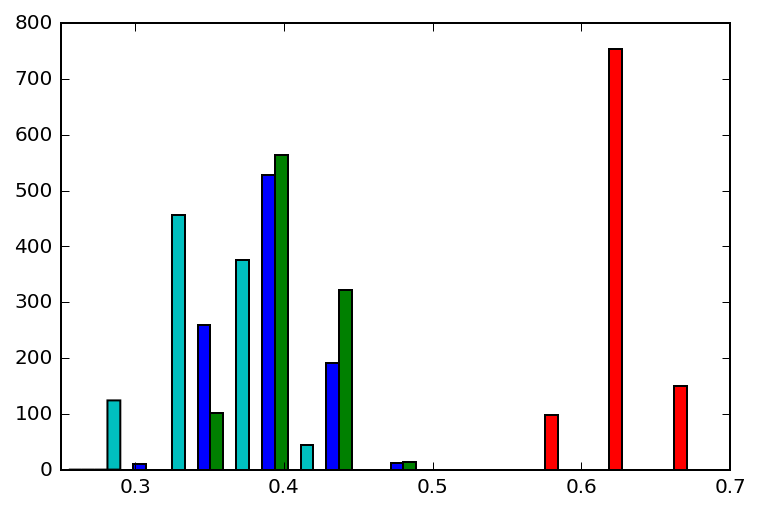

In [6]:
iters=iterations
chain_thin = 100
start = int(iters-1000)
esigma_low = np.where(samples_JAGS['e_sigma_a'][0,start::,:] <= samples_JAGS['e_sigma_a'][1,start::,:], samples_JAGS['e_sigma_a'][0,start::,:], samples_JAGS['e_sigma_a'][1,start::,:])
esigma_hi = np.where(samples_JAGS['e_sigma_a'][0,start::,:] > samples_JAGS['e_sigma_a'][1,start::,:], samples_JAGS['e_sigma_a'][0,start::,:], samples_JAGS['e_sigma_a'][1,start::,:])
f_low = np.where(samples_JAGS['e_sigma_a'][0,start::,:] <= samples_JAGS['e_sigma_a'][1,start::,:], samples_JAGS['f_a'][0,start::,:], samples_JAGS['f_a'][1,start::,:])
f_hi = np.where(samples_JAGS['e_sigma_a'][0,start::,:] > samples_JAGS['e_sigma_a'][1,start::,:], samples_JAGS['f_a'][0,start::,:], samples_JAGS['f_a'][1,start::,:])
print(np.min(f_hi))
plt.hist(f_low)


6
$e_{\sigma_{b}}$
$f_{a_{low}}$
$e_{\sigma_{a_{high}}}$
$P_{break}$
$e_{\sigma_{a_{low}}}$
$f_{a_{high}}$


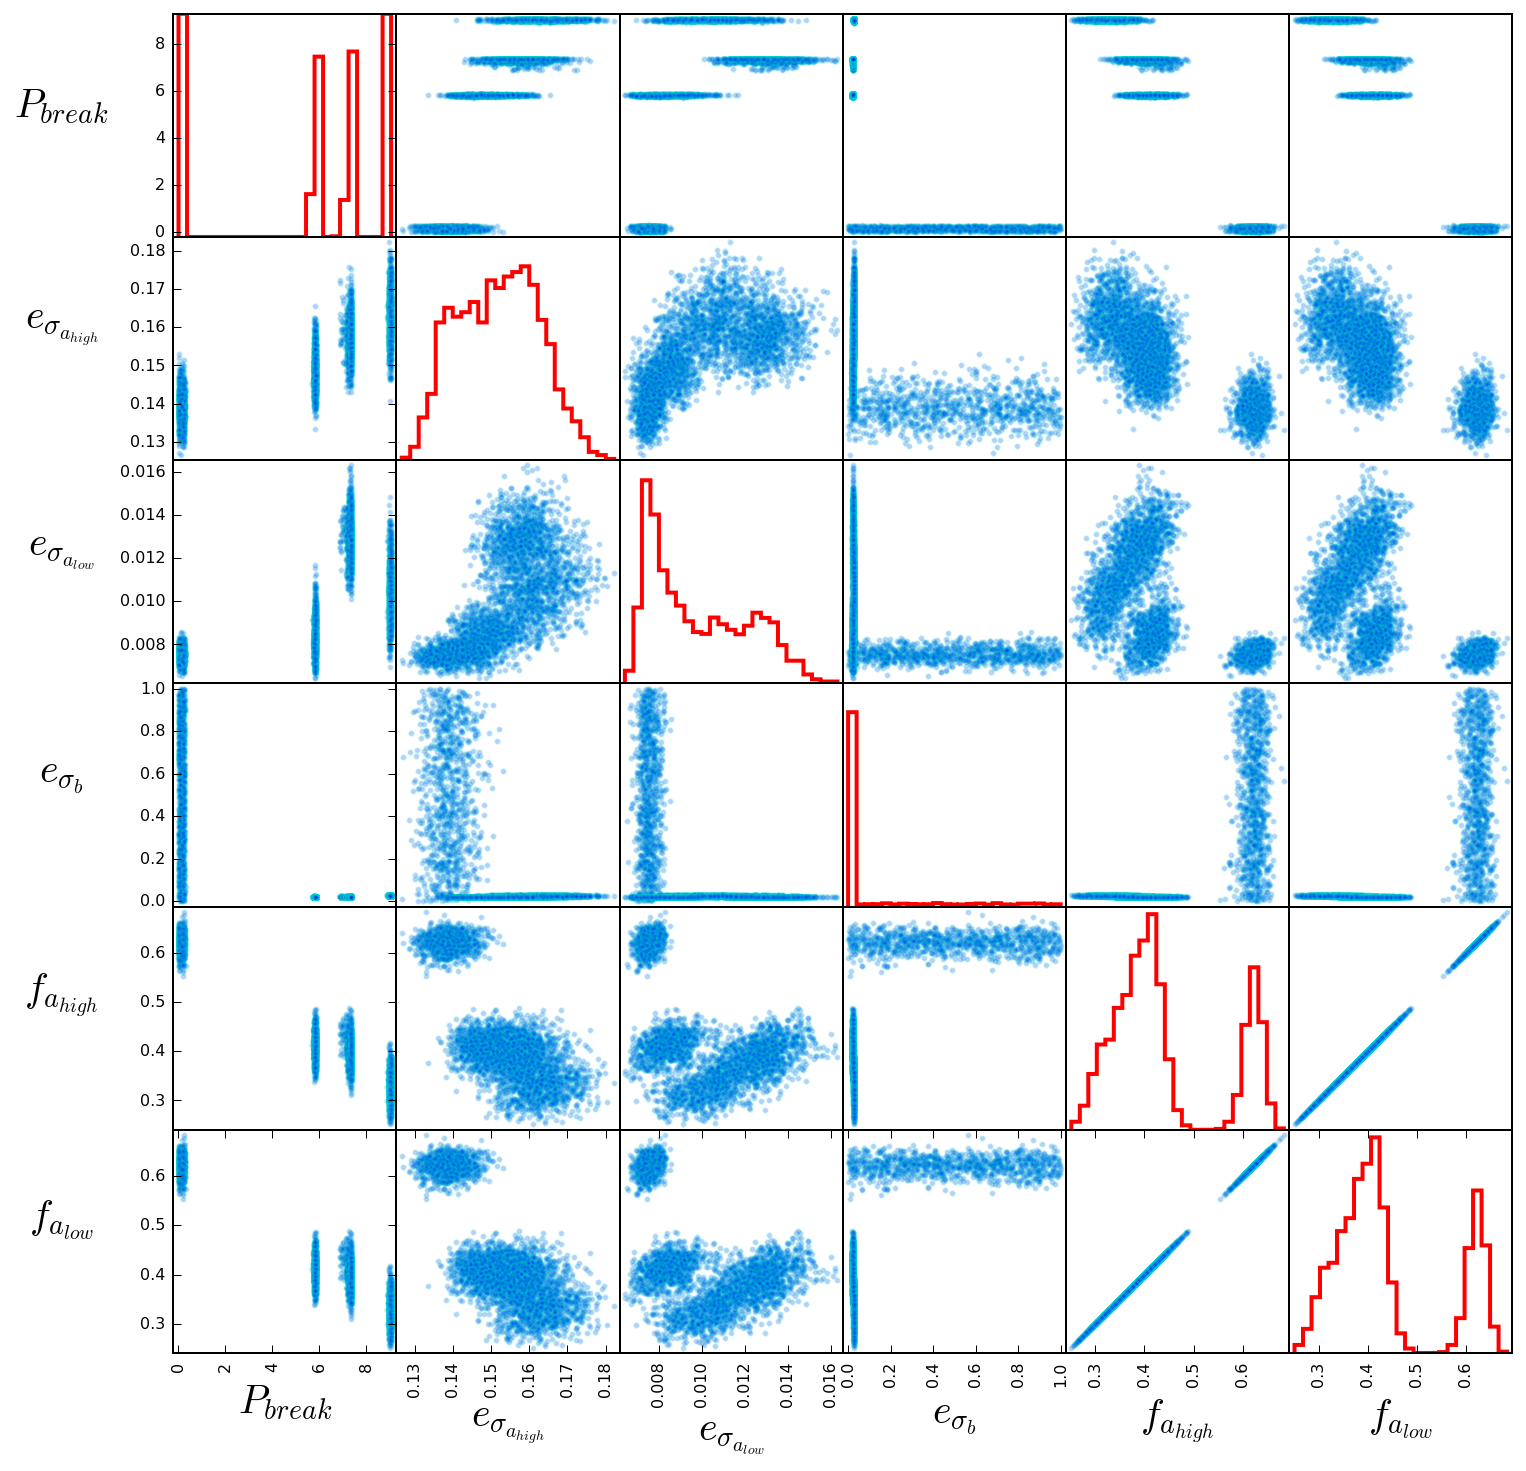

In [7]:
## Scatter matrix plot:

## Redefine the trace so that we only vizualize every 10th latent variable element in 
## the scatter_matrix plot below. Vizualizing all 50 is too cumbersome for the scatter
## matrix. 

samples_EB_for_scatter_matrix = {}
numHyperParams = 6
dim = numHyperParams
print(dim)

samples_EB_for_scatter_matrix.update({'$f_{a_{low}}$': f_low})
samples_EB_for_scatter_matrix.update({'$e_{\sigma_{a_{low}}}$': esigma_low})
samples_EB_for_scatter_matrix.update({'$f_{a_{high}}$': f_low})
samples_EB_for_scatter_matrix.update({'$e_{\sigma_{a_{high}}}$': esigma_hi})
samples_EB_for_scatter_matrix.update({'$e_{\sigma_{b}}$': samples_JAGS['e_sigma_b'][0,start::,:]})
samples_EB_for_scatter_matrix.update({'$P_{break}$': samples_JAGS['p_break'][0,start::,:]})

for j, i in samples_EB_for_scatter_matrix.items():
    print(j)
#    print(i)

trace_2 = pd.Panel({k: v for k, v in samples_EB_for_scatter_matrix.items()})

sm = scatter_matrix(trace_2.to_frame(),  color="darkturquoise", alpha=0.2, figsize=(dim*2, dim*2), diagonal='hist',hist_kwds={'bins':25,'histtype':'step', 'edgecolor':'r','linewidth':2})
## y labels size
[plt.setp(item.yaxis.get_label(), 'size', 20) for item in sm.ravel()]
## x labels size 
[plt.setp(item.xaxis.get_label(), 'size', 20) for item in sm.ravel()]
## Change label rotation
## This is helpful for very long labels
#[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.xaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
## May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.5,0.5) for s in sm.reshape(-1)]
## Hide all ticks
#[s.set_xticks(()) for s in sm.reshape(-1)]
#[s.set_yticks(()) for s in sm.reshape(-1)]

plt.savefig('scatter_matrix_period_break_point.png')


Variable
$P_{break}$                5.567903
$e_{\sigma_{a_{high}}}$    0.151951
$e_{\sigma_{a_{low}}}$     0.009854
$e_{\sigma_{b}}$           0.141988
$f_{a_{high}}$             0.441038
$f_{a_{low}}$              0.441038
dtype: float64
Variable  $P_{break}$  $e_{\sigma_{a_{high}}}$  $e_{\sigma_{a_{low}}}$  \
0.05         0.047869                 0.135590                0.007182   
0.95         9.045642                 0.168916                0.013782   

Variable  $e_{\sigma_{b}}$  $f_{a_{high}}$  $f_{a_{low}}$  
0.05              0.020716        0.303350       0.303350  
0.95              0.805281        0.636499       0.636499  


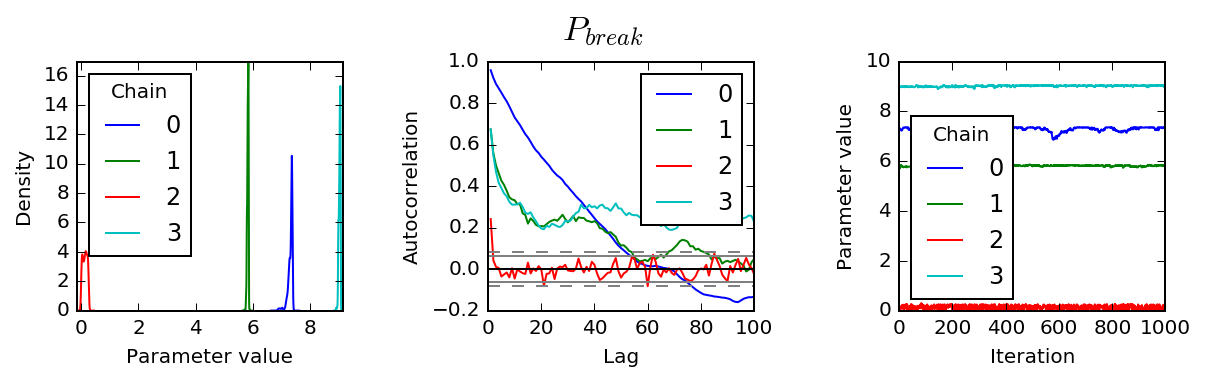

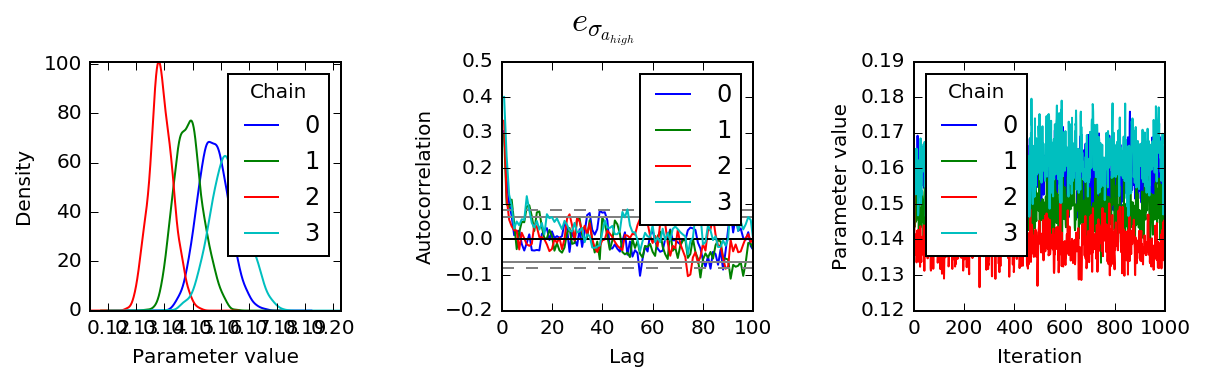

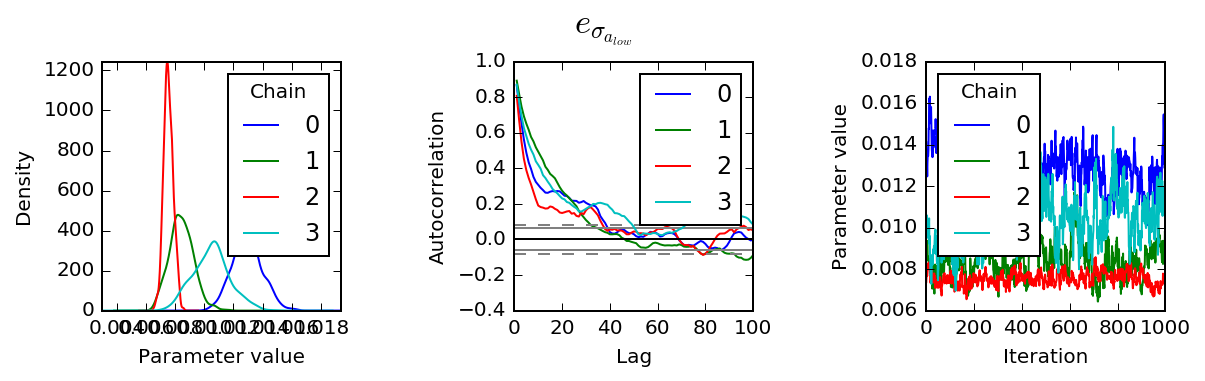

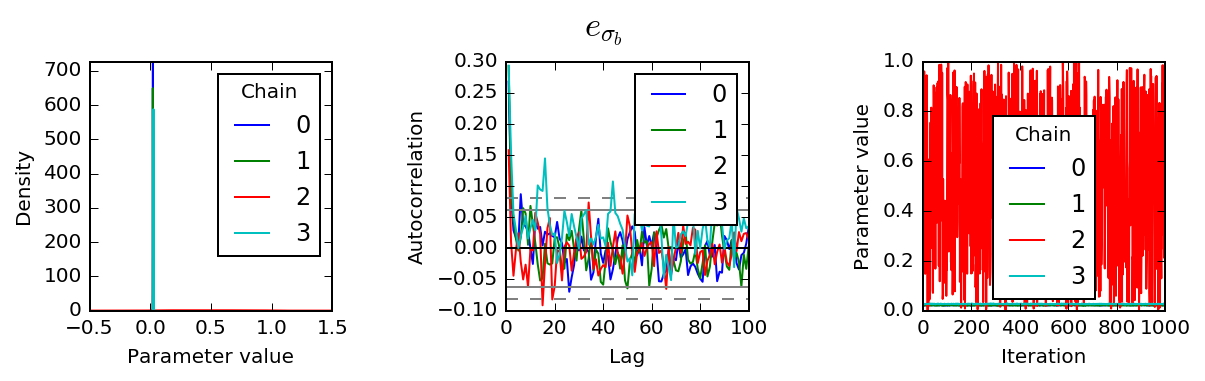

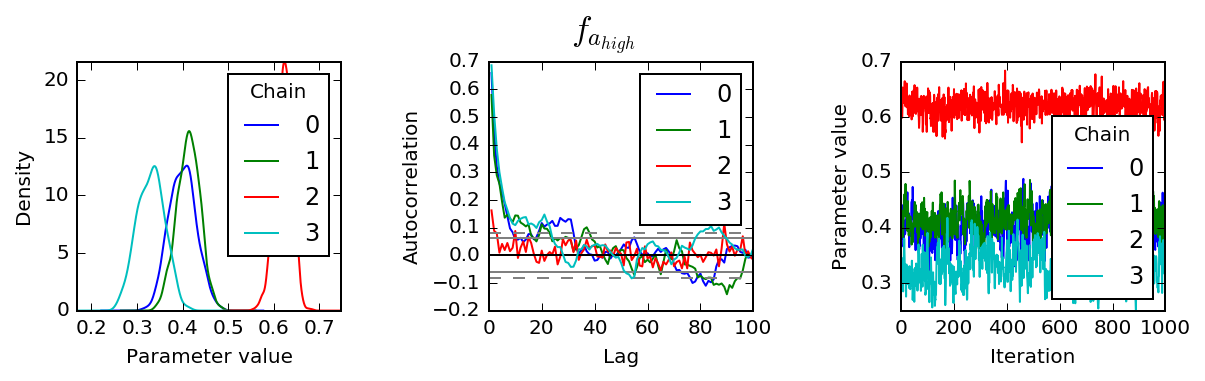

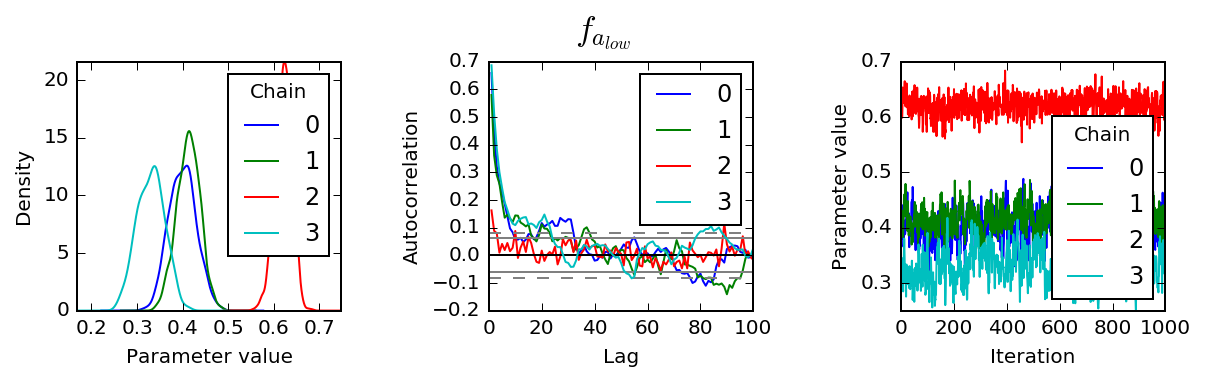

In [8]:
## Use pandas three dimensional Panel to represent the trace:

trace = pd.Panel({k: v for k, v in samples_EB_for_scatter_matrix.items()})
trace.axes[0].name = 'Variable'
trace.axes[1].name = 'Iteration'
trace.axes[2].name = 'Chain'
 
## Point estimates:
print(trace.to_frame().mean())
 
## Bayesian equal-tailed 95% credible intervals:
print(trace.to_frame().quantile([0.05, 0.95]))
  ## ^ entering the values here could be a good question part
    
def plot(trace, var):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(var, y=0.95, fontsize='xx-large')
 
    ## Marginal posterior density estimate:
    trace[var].plot.density(ax=axes[0])
    axes[0].set_xlabel('Parameter value')
    axes[0].locator_params(tight=True)
 
    ## Autocorrelation for each chain:
    axes[1].set_xlim(0, 100)
    for chain in trace[var].columns:
        autocorrelation_plot(trace[var,:,chain], axes[1], label=chain)
 
    ## Trace plot:
    axes[2].set_ylabel('Parameter value')
    trace[var].plot(ax=axes[2])
 
    ## Save figure
    filename = var.replace("\\", "") 
    filename = filename.replace("/", "") 
    filename = filename.replace("$", "") 
    filename = filename.replace("}", "") 
    filename = filename.replace("{", "") 
    plt.tight_layout(pad=3)
    fig.savefig('Break_point_'+'{}.png'.format(filename))

    
## Display diagnostic plots
for var in trace:
    plot(trace, var)
 


After evaluating the diagnostics, what would your next steps be, given you had more computing resources?